# MODELOS

## LIBRERÍAS

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet

In [3]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import r2_score

## LECTURA DE LOS DATOS

In [4]:
table_horaria = pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/Practices/EXAM/Exam_data/datos_horarios.parquet')
datos_horarios = table_horaria.to_pandas()

#### ¿TIENEN LOS DATOS HORARIOS COMPONENTE ESTACIONAL HORARIA?

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_21467/2857939759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_horarios_new["hora"] = datos_horarios_new.index.hour + 1


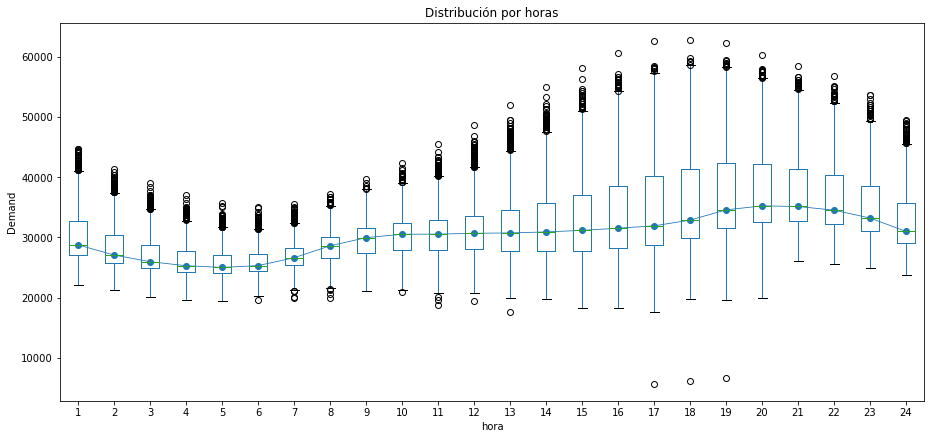

In [5]:
fig, ax = plt.subplots(figsize = (15, 7))
datos_horarios_new = datos_horarios[:]
datos_horarios_new["hora"] = datos_horarios_new.index.hour + 1
datos_horarios_new.boxplot(column="D", by="hora", ax=ax)
datos_horarios_new.groupby("hora")["D"].median().plot(style="-o", linewidth=0.8, ax=ax)
ax.set_ylabel("Demand")
ax.set_title("Distribución por horas")
fig.suptitle("");

Podemos observar como claramente aparece una componente estacional horaria en los datos. A la madrugada hay menos demanda que a las horas de la tarde por ejemplo.

## DESCOMPOSICIÓN STL

STL es un método para la descomposición de series temporales. Sus siglas corresponden a *Seasonal and Trend decomposition using Loess*.

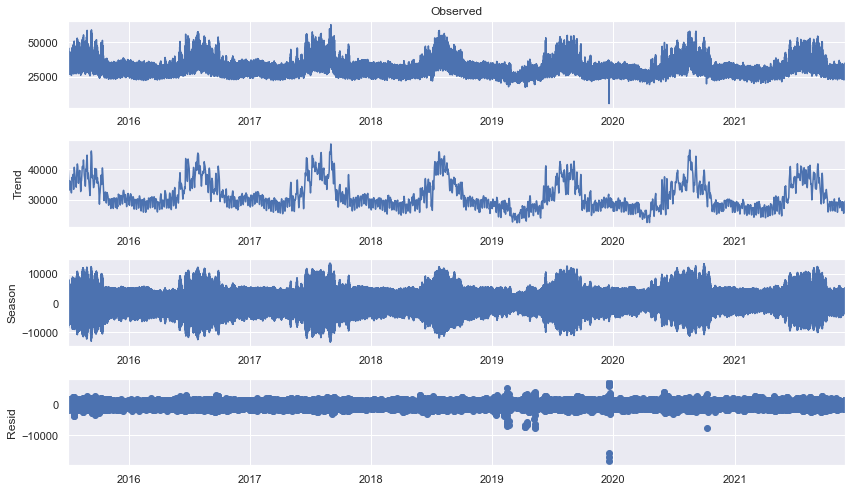

In [6]:
sns.set(rc={'figure.figsize':(12, 7)})

stl = STL(datos_horarios)
res = stl.fit()
fig = res.plot()

Podemos observar que los datos no tienen tendencia y, claramente vemos que la serie tiene componente estacional en los meses entre verano y otoño más o menos.

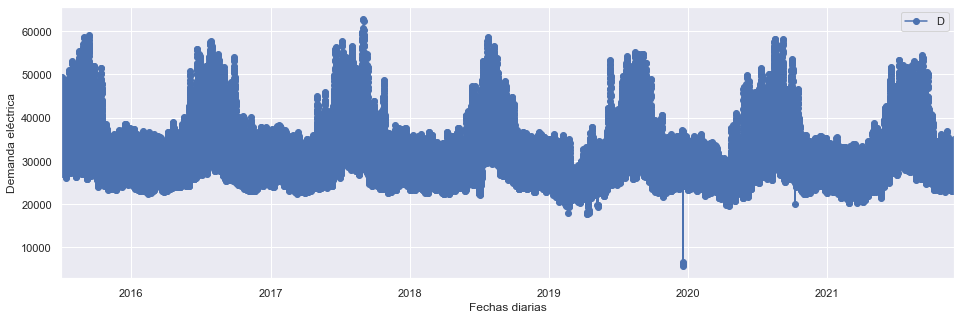

In [7]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_horarios.plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

Debido a que nuestro objetivo es predecir en el mes de diciembre, tomaremos los datos desde octubre del 2021. Dado que no nos encontramos en fechas de verano, y vemos claramente que el verano tiene un gran impacto en la demanda, eliminamos los datos que contengan meses de verano y comenzamos a analizar la serie desde octubre.

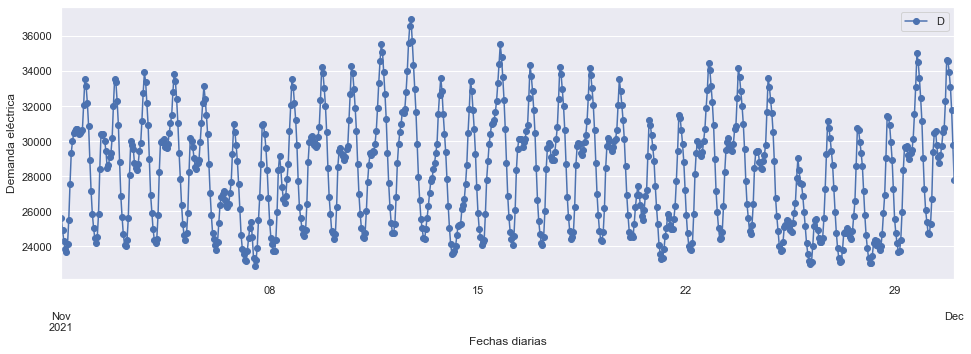

In [8]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_horarios["2021-11":].plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

In [9]:
datos_horarios_d_2021_11 = datos_horarios["2021-11":].to_period("H")

In [10]:
datos_horarios_d_2021_11 

,D
2021-11-01 00:00,25594.0
2021-11-01 01:00,24898.0
2021-11-01 02:00,24312.0
2021-11-01 03:00,23841.0
2021-11-01 04:00,23657.0
...,...
2021-11-30 20:00,33941.0
2021-11-30 21:00,33098.0
2021-11-30 22:00,31768.0
2021-11-30 23:00,29751.0


Vamos a separar los datos en training y testing. Para el conjunto de testing vamos a tomar dos días, equivalentemente 48 horas y, por ende, debemos tomar 48 datos.

Las dimensiones del dataset de training y testing son: 649 y 72


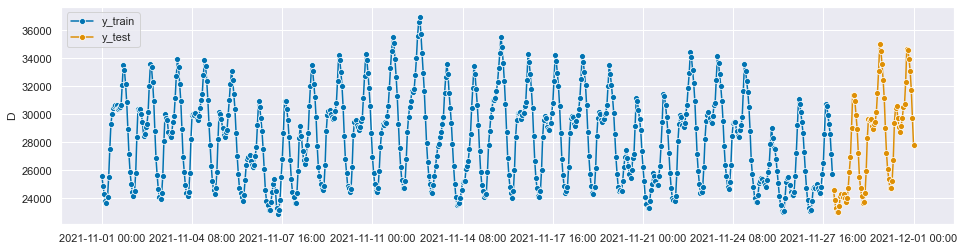

In [11]:
y_train_horario, y_test_horario = temporal_train_test_split(y = datos_horarios_d_2021_11["D"].astype('float64'), test_size=72)
plot_series(y_train_horario, y_test_horario, labels=["y_train", "y_test"])
print("Las dimensiones del dataset de training y testing son:" ,y_train_horario.shape[0], "y", y_test_horario.shape[0])

### MODELO BASE

El modelo base del que haremos uso será el método ingenuo (Naive). Este método es utilizado en series temporales con componente estacional. Sencillamente, si por ejemplo queremos predecir datos trimestrales, la predicción del trimestre que queramos predecir tomará el valor del trimestre anterior. 

In [12]:
fh = np.arange(1, 73)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

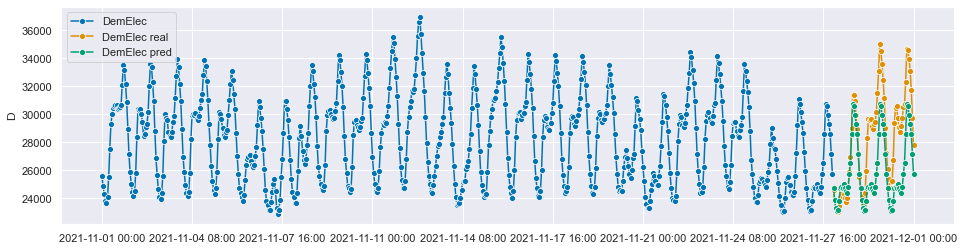

In [13]:
Met_Naive = NaiveForecaster(strategy="last", sp=24)

Met_Naive.fit(y_train_horario)

# step 5: querying predictions
pred_Naive = Met_Naive.predict(fh)

plot_series(y_train_horario, y_test_horario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])

Vamos a ampliar la predicción para verla mejor.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

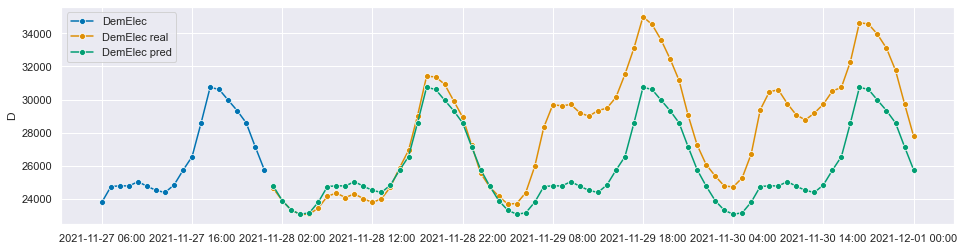

In [15]:
plot_series(y_train_horario[630:], y_test_horario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])

La predicción, a simple vista, vemos que falla mucho al principio. Sin embargo, a medida que avanza el tiempo acierta cada vez más. Para tener una visión estadística de la predicción, hallaremos el error cuadrático medio.

In [16]:
MAPE_NAIVE = mean_absolute_percentage_error(y_test_horario, pred_Naive)
MAPE_NAIVE

0.08523526849421949

In [17]:
rmse_NAIVE = MeanSquaredError(square_root=True)
rmse_NAIVE =rmse_NAIVE(y_test_horario, pred_Naive)
rmse_NAIVE

3038.8879727806866

In [18]:
r2_NAIVE = r2_score(y_test_horario, pred_Naive)
r2_NAIVE

0.20741394274925595

Este será nuestro modelo base y, a partir de aquí, todos los modelos que vayamos considerando deberán mejorar los resultados que acabamos de obtener.

## MODELO ETS

In [19]:
ETS_horario = AutoETS(auto=True, sp=24, n_jobs=-1) 

In [20]:
ETS_horario.fit(y_train_horario)
print(ETS_horario.summary())

                                 ETS Results                                  
Dep. Variable:                      D   No. Observations:                  649
Model:                      ETS(MAdM)   Log Likelihood               -4766.113
Date:                Fri, 31 Dec 2021   AIC                           9594.227
Time:                        13:47:37   BIC                           9732.965
Sample:                    11-01-2021   HQIC                          9648.044
                         - 11-28-2021   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.084     11.898      0.000       0.835       1.165
smoothing_trend         0.4700      0.147      3.201      0.001       0.182       0.758
smoothing_season

In [21]:
ETS_horario_pred = ETS_horario.predict(fh)
print(ETS_horario_pred)

2021-11-28 01:00    24829.931741
2021-11-28 02:00    24141.771561
2021-11-28 03:00    23754.317053
2021-11-28 04:00    23665.644026
2021-11-28 05:00    23957.845476
                        ...     
2021-11-30 20:00    31677.496662
2021-11-30 21:00    30769.826307
2021-11-30 22:00    29603.924689
2021-11-30 23:00    27921.632507
2021-12-01 00:00    26341.641857
Freq: H, Length: 72, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

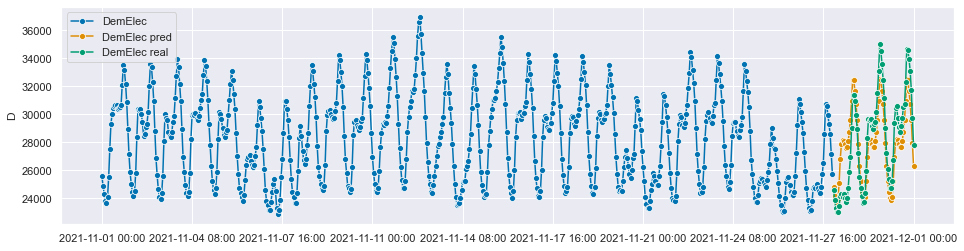

In [22]:
plot_series(y_train_horario, ETS_horario_pred, y_test_horario, labels=["DemElec", "DemElec pred", "DemElec real"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

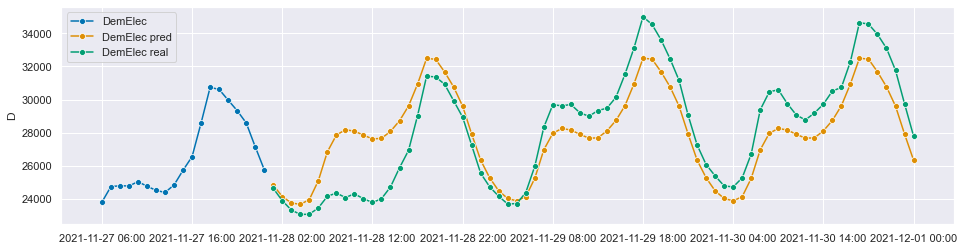

In [23]:
plot_series(y_train_horario[630:], ETS_horario_pred, y_test_horario, labels=["DemElec", "DemElec pred", "DemElec real"])

#### MÉTRICAS

Vemos que la predicción es realmente mala. Veamos cuales son los valores de las métricas de error.

In [24]:
MAPE_ETS = mean_absolute_percentage_error(y_test_horario, ETS_horario_pred)
MAPE_ETS

0.0571393642334629

In [25]:
rmse_ETS = MeanSquaredError(square_root=True)
rmse_ETS = rmse_ETS(y_test_horario, ETS_horario_pred)
rmse_ETS

1874.0983632420157

In [26]:
r2_ETS = r2_score(y_test_horario, ETS_horario_pred)
r2_ETS

0.6985593550457725

Vemos que las métricas son bastante peores que las obtenidas con el modelo base. Luego, no es un buen modelo.

## MODELO ARIMA

La serie que estamos analizando es estacionaria en media pero, no lo es en varianza. Luego, deberemos transformar la serie. La transformación la haremos haciendo uso de la función logaritmo.

In [27]:
ARIMA_horario = AutoARIMA(sp=24, suppress_warnings=True)

#  Auto ARIMA Model Estimation
ARIMA_horario.fit(y_train_horario)

AutoARIMA(sp=24, suppress_warnings=True)

In [28]:
print(ARIMA_horario.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  649
Model:             SARIMAX(3, 0, 4)x(2, 0, [], 24)   Log Likelihood               -4826.326
Date:                             Fri, 31 Dec 2021   AIC                           9674.653
Time:                                     13:55:12   BIC                           9723.883
Sample:                                          0   HQIC                          9693.749
                                             - 649                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2569.1126   1180.478      2.176      0.030     255.419    4882.806
ar.L1         -0.7315      

In [29]:
y_pred_horario_ARIMA = ARIMA_horario.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

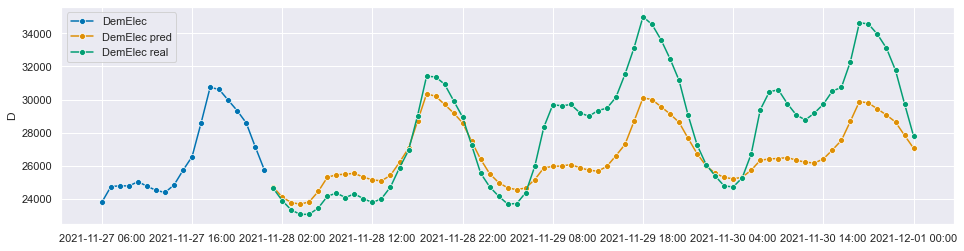

In [30]:
plot_series(y_train_horario[630:], y_pred_horario_ARIMA, y_test_horario, labels=["DemElec", "DemElec pred", "DemElec real"])

#### MÉTRICAS

In [31]:
MAPE_ARIMA = mean_absolute_percentage_error(y_test_horario, y_pred_horario_ARIMA)
MAPE_ARIMA

0.07120916875696977

In [32]:
rmse_ARIMA = MeanSquaredError(square_root=True)
rmse_ARIMA = rmse_ARIMA(y_test_horario, y_pred_horario_ARIMA)
rmse_ARIMA

2550.693591665879

In [33]:
r2_ARIMA = r2_score(y_test_horario, y_pred_horario_ARIMA)
r2_ARIMA

0.4416151460072416

## MODELO PROPHET

In [34]:
y = datos_horarios["2021-11":].reset_index(drop=False)
y.columns = ["ds", "y"]
y.tail()

,ds,y
716,2021-11-30 20:00:00,33941.0
717,2021-11-30 21:00:00,33098.0
718,2021-11-30 22:00:00,31768.0
719,2021-11-30 23:00:00,29751.0
720,2021-12-01 00:00:00,27799.0


In [35]:
train = y.iloc[:649,:]
test = y.iloc[649:,:]

In [36]:
len(test)

72

In [37]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.89026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1969.36    0.00285239       415.806           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1971.33   0.000869149       112.695           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       1972.11   0.000189782       241.894   6.627e-07       0.001      320  LS failed, Hessian reset 
     299       1973.19    0.00283992       91.1779      0.2226           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300        1973.2   0.000856754       223.984   9.397e-06       0.001      472  LS failed, Hessian reset 
     330       1973.31   0.000155312       201.987   1.463e-06       0.001      550  LS failed, Hessian rese

In [38]:
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)

     65.5096   2.533e-07       0.001      636  LS failed, Hessian reset 
     399       1973.33   5.94256e-05        73.875           1           1      687   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1973.5   8.37245e-05        67.852      0.8045      0.8045      811   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     531        1973.5   2.50219e-07       64.2456           1           1      853   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


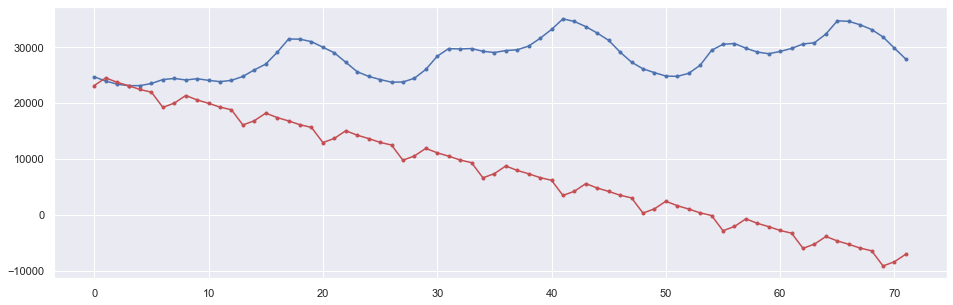

In [39]:
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[649:,'yhat']),'r.-')
plt.show()

#### MÉTRICAS

In [40]:
r2_PROPHET = r2_score(list(test['y']), list(forecast.loc[649:,'yhat']))
r2_PROPHET

-46.39415333417342

In [41]:
MAPE_PROPHET = mean_absolute_percentage_error(test["y"], forecast.loc[649:,'yhat'])
MAPE_PROPHET

1.1442207284242325

In [42]:
rmse_PROPHET = MeanSquaredError(square_root=True)
rmse_PROPHET = rmse_PROPHET(test["y"], forecast.loc[649:,'yhat'])
rmse_PROPHET

23499.242384998754

### RESUMEN MÉTRICAS DE TODOS LOS MODELOS

In [43]:
MAPE = [MAPE_NAIVE, MAPE_ETS, MAPE_ARIMA, MAPE_PROPHET]
RMSE = [rmse_NAIVE, rmse_ETS, rmse_ARIMA, rmse_PROPHET]
R2 = [r2_NAIVE, r2_ETS, r2_ARIMA, r2_PROPHET]
data = {"MAPE": MAPE, "RMSE":RMSE, "R2":R2}
df_metricas = pd.DataFrame(data, columns=["MAPE", "RMSE", "R2"])
df_metricas.index=["Naive", "ETS", "ARIMA", "Prophet"]
df_metricas

,MAPE,RMSE,R2
Naive,0.085235,3038.887973,0.207414
ETS,0.057139,1874.098363,0.698559
ARIMA,0.071209,2550.693592,0.441615
Prophet,1.144221,23499.242385,-46.394153
